# Initial Excercise - Validation Test


   RESULTADOS DEL MODELO DE ELASTICIDAD
Pass-through (Transmisión):      85.41%
Elasticidad Sell-out:            -1.53
Elasticidad Real (Efectiva):     -1.31


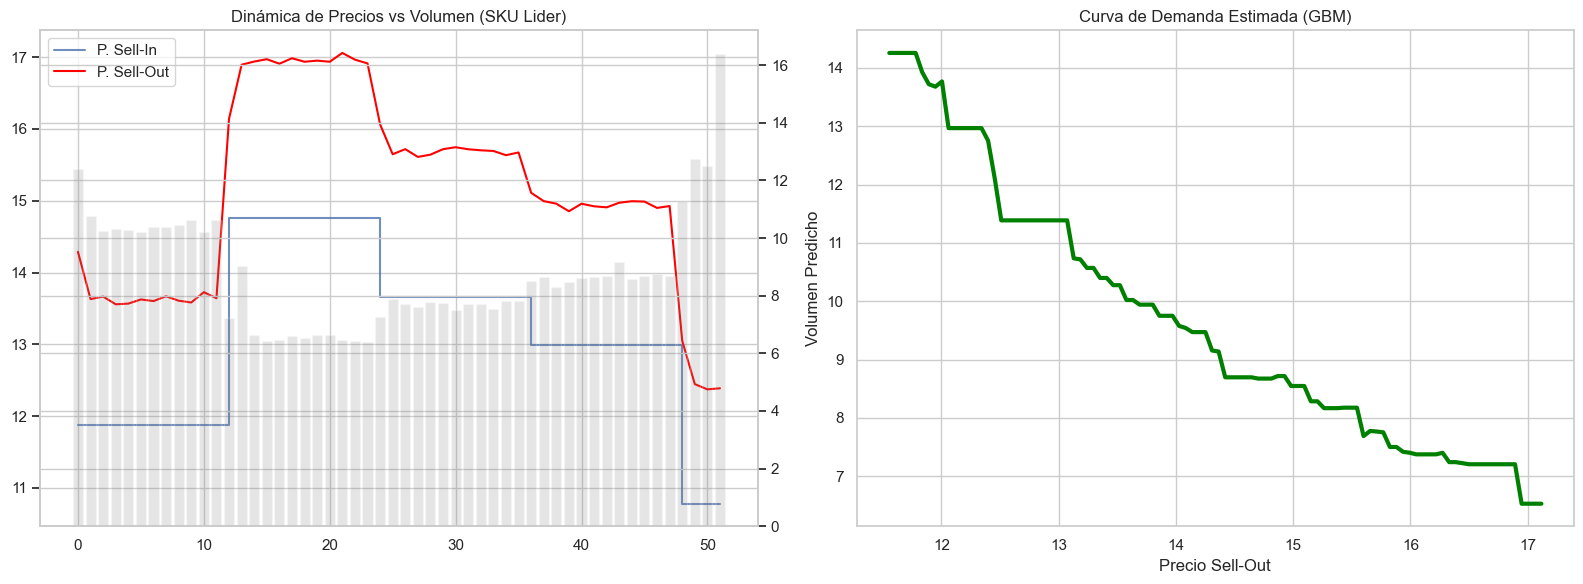

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

# SETTING ENVIRONMENT TO AVOID WINDOWS ERRORS
os.environ['LOKY_MAX_CPU_COUNT'] = '4'


sns.set_theme(style="whitegrid")

# Creating Mock-data for 2 products with different market behavior
np.random.seed(42)
weeks = 156 
products = ['SKU_Lider', 'SKU_Premium']
data_list = []

for prod in products:
    # Sell-in: Price Changes every 12 weeks
    sell_in = np.repeat(np.random.uniform(10, 15, size=weeks//12 + 1), 12)[:weeks]
    
    # Sell-out: 75% of transfering (Pass-through) with noise
    sell_out = 1.15 * (0.75 * sell_in + 0.25 * np.roll(sell_in, 1)) + np.random.normal(0, 0.05, weeks)
    
    # Calendar: Weeks and Holidays 
    week_num = np.arange(weeks) % 52
    is_holiday = np.where(np.isin(week_num, [51, 52, 0, 13]), 1, 0)
    
    # Volume: Real Elasticity of -2.1 and Holidays effect
    # We use a logarithm relation to ensure elasticity interpretability
    noise = np.random.normal(1, 0.02, weeks)
    volume = (2500 * (sell_out**-2.1) * (1 + 0.3 * is_holiday)) * noise
    
    df = pd.DataFrame({
        'Semana_Anual': week_num,
        'Es_Feriado': is_holiday,
        'Precio_Sell_In': sell_in,
        'Precio_Sell_Out': sell_out,
        'Volumen': volume,
        'Producto': prod
    })
    data_list.append(df)

df_total = pd.concat(data_list).reset_index(drop=True)
df_total['Producto'] = df_total['Producto'].astype('category')

# MODEL TRAINING (GBM)
features = ['Semana_Anual', 'Es_Feriado', 'Precio_Sell_Out', 'Producto']
X = df_total[features]
y = df_total['Volumen']

# n_jobs=1 y verbose=-1 to avoid paralelism warnings in Windows/Conda
model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, n_jobs=1, verbose=-1)
model.fit(X, y)

# METRIC CALCULATION (Pass-through and Elasticities)

# Pass-through: Regression over the differences (deltas) to detect transfer
# A. Delta P_out = beta * Delta P_in
d_in = df_total['Precio_Sell_In'].diff().fillna(0).values.reshape(-1, 1)
d_out = df_total['Precio_Sell_Out'].diff().fillna(0).values
from sklearn.linear_model import LinearRegression
pt_model = LinearRegression(fit_intercept=False).fit(d_in, d_out)
pass_through = pt_model.coef_[0]

# B. Sell Out Elasticity: (dQ/Q) / (dP/P) using model predictions
prices = df_total['Precio_Sell_Out'].values
vols_pred = model.predict(X)

# Calculating point to point elasticity
# Aproximated Derivative: % Volume Change  / % orice change
pct_change_q = np.gradient(vols_pred) / vols_pred
pct_change_p = np.gradient(prices) / prices
# Filtering Zero Division and Inf 
elasticities = pct_change_q / pct_change_p
elasticidad_sell_out = np.nanmedian(elasticities[np.isfinite(elasticities)])

# C. Real Elasticity (Elasticidad Efectiva del Sell-in)
elasticidad_real = elasticidad_sell_out * pass_through

# OUTPUT AND PLOTS
print("\n" + "="*45)
print("   RESULTADOS DEL MODELO DE ELASTICIDAD")
print("="*45)
print(f"Pass-through (Transmisión):      {pass_through:.2%}")
print(f"Elasticidad Sell-out:            {elasticidad_sell_out:.2f}")
print(f"Elasticidad Real (Efectiva):     {elasticidad_real:.2f}")
print("="*45)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Time Series (Visual Validation)
sku_plot = df_total[df_total['Producto'] == 'SKU_Lider']
ax1.step(sku_plot.index[:52], sku_plot['Precio_Sell_In'][:52], label='P. Sell-In', where='post', alpha=0.8)
ax1.plot(sku_plot.index[:52], sku_plot['Precio_Sell_Out'][:52], label='P. Sell-Out', color='red')
ax1_vol = ax1.twinx()
ax1_vol.bar(sku_plot.index[:52], sku_plot['Volumen'][:52], alpha=0.2, color='gray', label='Volumen')
ax1.set_title("Dinámica de Precios vs Volumen (SKU Lider)")
ax1.legend(loc='upper left')

# Plot 2: Estimate Elasticity Curve
# Simulating price impact holding everything else constant
p_range = np.linspace(df_total['Precio_Sell_Out'].min(), df_total['Precio_Sell_Out'].max(), 100)
X_sim = pd.DataFrame({
    'Semana_Anual': 20, 'Es_Feriado': 0, 
    'Precio_Sell_Out': p_range, 'Producto': 'SKU_Lider'
})
X_sim['Producto'] = X_sim['Producto'].astype('category')
y_sim = model.predict(X_sim)

ax2.plot(p_range, y_sim, color='green', linewidth=3)
ax2.set_title("Curva de Demanda Estimada (GBM)")
ax2.set_xlabel("Precio Sell-Out")
ax2.set_ylabel("Volumen Predicho")

plt.tight_layout()
plt.show()